In [41]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from typing import Union
from tqdm import tqdm

In [2]:
data = yf.download(
    tickers= "AAPL",
    start="2009-12-30",
    end="2016-12-30"
)

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-30,7.458214,7.571429,7.439643,7.558571,6.424353,412084400
2009-12-31,7.611786,7.619643,7.520000,7.526071,6.396729,352410800
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.496294,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.507527,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.404015,552160000
...,...,...,...,...,...,...
2016-12-22,29.087500,29.127501,28.910000,29.072500,27.128506,104343600
2016-12-23,28.897499,29.129999,28.897499,29.129999,27.182161,56998000
2016-12-27,29.129999,29.450001,29.122499,29.315001,27.354795,73187600


<Axes: title={'center': 'AAPL close prices'}, xlabel='Date'>

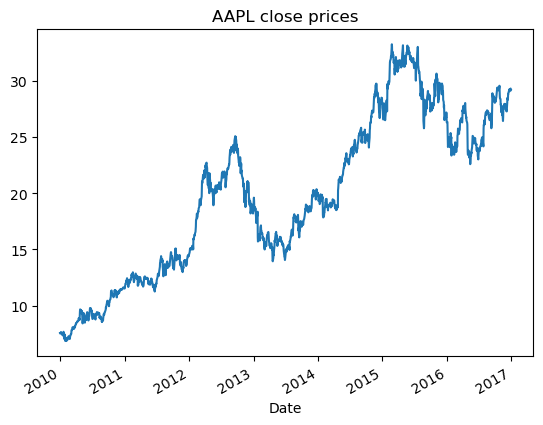

In [4]:
data["Close"].plot(
    title= "AAPL close prices"
)

In [5]:
len(data)

1763

In [6]:
data.iloc[2]

Open         7.622500e+00
High         7.660714e+00
Low          7.585000e+00
Close        7.643214e+00
Adj Close    6.496294e+00
Volume       4.937296e+08
Name: 2010-01-04 00:00:00, dtype: float64

In [28]:
class StockDataset(Dataset):
    def __init__(self,
                 data : Union[pd.Series, pd.DataFrame],
                 lookback : int) -> None:
        super().__init__()
        self.data = data
        self.lookback = lookback

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index : int):
        if index < self.lookback:
            X =self.data\
                .iloc[:index]\
                .dropna()\
                .values
            
            X = torch.tensor(X)
            X = torch.cat([X, torch.zeros(self.lookback - X.size(0) )])

            y = self.data.iloc[index]
            if np.isnan(y):
                y = 0
            return X, y

        X = self.data\
            .iloc[index - self.lookback : index]\
            .values

        X = torch.tensor(X)

        y = self.data.iloc[index]    
        return X, y
              

(tensor([ 0.0100,  0.0217, -0.0142, -0.0176,  0.0016, -0.0073, -0.0159, -0.0426,
          0.0192,  0.0183], dtype=torch.float64),
 -0.006240808574875967)

## Building LSTM model


In [62]:
lookback = 10
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 20


In [67]:
aapl_dataset = StockDataset(
    data["Close"].pct_change(),
    lookback=lookback
)

aapl_dataloader = DataLoader(
    aapl_dataset,
    batch_size= 1,
    shuffle= False
)

In [83]:
class GRU(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hidden_dim, 
                 num_layers, 
                 output_dim
                ):
        
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        print(h0.shape, x.shape)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [84]:
gru = GRU(
    input_dim,
    hidden_dim,
    num_layers,
    output_dim
)

In [85]:
treinable_params = sum(p.numel() for p in gru.parameters() if p.requires_grad)

In [86]:
treinable_params

9729

In [87]:
loss_fn = torch.nn.BCELoss(reduction='mean')
optimiser = torch.optim.Adam(gru.parameters(), lr=0.01)

In [89]:
X_batch.reshape([1,10,1])

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], dtype=torch.float64)

In [91]:
gru(X_batch)

RuntimeError: shape '[1, 10, 32]' is invalid for input of size 10

In [73]:
import time
history = np.zeros(num_epochs)
errors = []

for epoch in range(num_epochs):
    batch_error = torch.tensor([])
    for X_batch, y_batch in aapl_dataloader:
        print(X_batch)
        y_train_pred = gru(X_batch)
        loss = loss_fn(y_train_pred, y_batch)

        batch_error = torch.cat([batch_error, torch.tensor([loss.item()])])

        history[epoch] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        
        optimiser.step()

    errors = torch.cat([errors, torch.tensor([batch_error.mean()])])

    print(f"Epoch: {epoch}, mean error: {errors[-1]}")


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)


RuntimeError: For unbatched 2-D input, hx should also be 2-D but got 3-D tensor